# Project Part 2

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brearenee/NLP-Project/blob/main/part2-startrek.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/https://github.com/brearenee/NLP-Project/blob/main/part2-startrek.ipynb)


**NLP Problem:** Predicting the speaker from Star Trek: The Next Generation script lines for 8 main characters.

In this second phase of my project, I'm developing a foundational model for this NLP task.

As learned in Part 1, the initial dataset's structure is less than ideal. To start Part 2, we must parse and clean the raw JSON data and transform it into a structured DataFrame.

In [1]:
import pandas as pd
import json
import requests

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = 'https://raw.githubusercontent.com/brearenee/NLP-Project/main/dataset/StarTrekDialogue_v2.json'
response = requests.get(url)

##This CodeBlock is thanks to ChatGPT :-) 
if response.status_code == 200:
    json_data = json.loads(response.text)
    lines = []
    characters = []
    episodes = []
  
    # extract the information from the JSON file for the "TNG" series
    for series_name, series_data in json_data.items():
        if series_name == "TNG": 
            for episode_name, episode_data in series_data.items():
                for character_name, character_lines in episode_data.items():
                    for line_text in character_lines:
                        lines.append(line_text)
                        characters.append(character_name)
                        episodes.append(episode_name)
                     
    # Create a DataFrame from the extracted data
    df = pd.DataFrame({
        'Line': lines,
        'Character': characters,
        'Episode': episodes,
    })

    # Remove duplicate lines, keeping the first occurrence (preserving the original order)
    df = df.drop_duplicates(subset='Line', keep='first')

    # Reset the index of the DataFrame
    df.reset_index(drop=True, inplace=True)

else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


We are now going to remove outliers by removing all characters that have less than 1000 lines. 


In [3]:
character_counts = df['Character'].value_counts()

characters_to_remove = character_counts[character_counts < 1000].index
df = df[~df['Character'].isin(characters_to_remove)]


In [4]:
df['Character'].value_counts()


Character
PICARD     10798
RIKER       6454
DATA        5699
LAFORGE     4111
WORF        3185
CRUSHER     2944
TROI        2856
WESLEY      1206
Name: count, dtype: int64

# Decision Tree
For my simple model, I'll be using a Decision Tree Classifier. 


In [5]:
# Vectorize the "Line" column using a "bag of words" representation.  
# This represntation converts the lines of text into a numerical format 
# that can be used by the DecisionTreeClassifier for prediction.
vectorizer = CountVectorizer()

#extract the lines from my dataframe
lines = df['Line'].tolist()
character = df['Character'].tolist()

X = vectorizer.fit_transform(lines)
y = character

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Examine the distribution for the test data
y_test_series = pd.Series(y_test)
test_class_distribution = y_test_series.value_counts()
print(test_class_distribution)



PICARD     2146
RIKER      1283
DATA       1152
LAFORGE     822
WORF        639
CRUSHER     591
TROI        569
WESLEY      249
Name: count, dtype: int64


In [7]:
# Create and train the Decision Tree model
model1 = DecisionTreeClassifier(
    random_state=42)
model1.fit(X_train, y_train)


# Make predictions on the test set and evaluate the model
y_pred = model1.predict(X_test)
accuracy1 = accuracy_score(y_test, y_pred)
precision1 = precision_score(y_test, y_pred, average='weighted')
recall1 = recall_score(y_test, y_pred, average='weighted')
f11 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy1}')
print(f'Precision: {precision1}')
print(f'Recall: {recall1}')
print(f'F1: {f11}')

Accuracy: 0.3206281036102537
Precision: 0.3021840062767826
Recall: 0.3206281036102537
F1: 0.30843041409046174


Upon examination of our performance metrics, none of them are performing exceptionally well. Although the ~32% accuracy surpasses random guessing in our 8-class classification scenario, there is definitely room for improvement.

**Next lets modify some hyperparameters in hopes of getting more accurate predictions.** 

In [8]:
model2 = DecisionTreeClassifier(
    random_state=42,
    max_depth=20, 
    #min_samples_split=5,  
    #min_samples_leaf=1,  
    #max_features='sqrt',  
    #criterion='entropy' 
)
model2.fit(X_train, y_train)

# Make predictions on the test set and evaluate the model
y_pred = model2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred)
precision2 = precision_score(y_test, y_pred, average='weighted')
recall2 = recall_score(y_test, y_pred, average='weighted')
f12 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy2}')
print(f'Precision: {precision2}')
print(f'Recall: {recall2}')
print(f'F1: {f12}')



Accuracy: 0.3482753992752651
Precision: 0.33212301558527724
Recall: 0.3482753992752651
F1: 0.2598774096826694


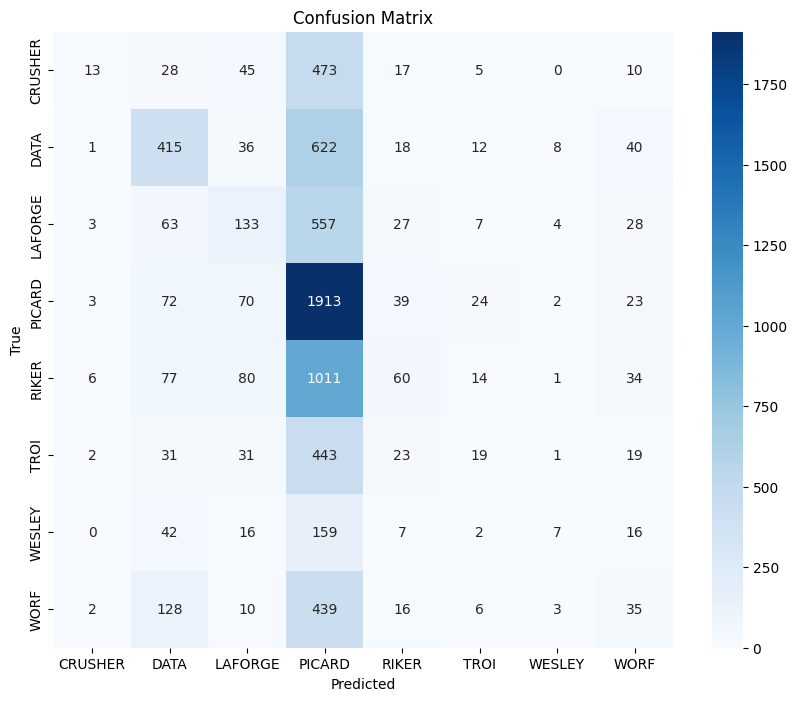

In [9]:

classes = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

After exploring various hyperparameters and getting marginal improvements in accuracy, I've decided to shift gears. 

Departing from the conventional Bag of Words approach, I'm now experimenting with TF-IDF for a different representation of the textual data to hopefully enhance model performance. 

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

#TF-IDF vecotorization instead of Bag of Words. 
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lines)
y = character


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adjust hyperparameters 
model3 = DecisionTreeClassifier(
    random_state=42,
    max_depth=20,
    #min_samples_split=5,
    #min_samples_leaf=2,
    #max_features='sqrt',
    #criterion='gini'
)


model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred)
precision3 = precision_score(y_test, y_pred, average='weighted')
recall3 = recall_score(y_test, y_pred, average='weighted')
f13 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy3}')
print(f'Precision: {precision3}')
print(f'Recall: {recall3}')
print(f'F1: {f13}')

Accuracy: 0.34263857200375786
Precision: 0.30951702483529997
Recall: 0.34263857200375786
F1: 0.25516846031454665


Transitioning from a bag-of-words representation to TF-IDF yielded minimal change. In fact, accuracy experienced a slight decrease. 

My next step will be to explore a different model- Random Forest, while maintaining the TF-IDF methodology. This shift aims to assess whether a different model can bring about improvements in performance.


# Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
model4 = RandomForestClassifier(random_state=42)
model4.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model4.predict(X_test)

# Evaluate the model
accuracy4 = accuracy_score(y_test, y_pred)
precision4 = precision_score(y_test, y_pred, average='weighted')
recall4 = recall_score(y_test, y_pred, average='weighted')
f14 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy4}')
print(f'Precision: {precision4}')
print(f'Recall: {recall4}')
print(f'F1: {f14}')

Accuracy: 0.41068312978123744
Precision: 0.4213432876008998
Recall: 0.41068312978123744
F1: 0.3505411781979835


There was a significant improvement with this Random Forest model.  
Next, lets adjust the hyper parameters of this mdoel in hopes of getting an even better prediction. 

Accuracy: 0.4100120789155818
Precision: 0.42463853981887406
Recall: 0.4100120789155818
F1: 0.34610996336558253


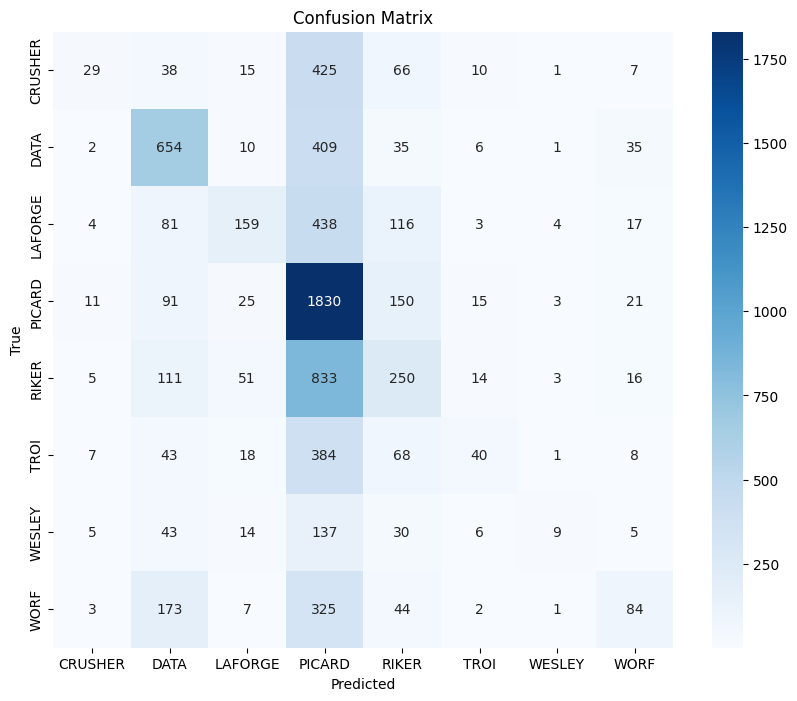

In [12]:

model5 = RandomForestClassifier(
    random_state=42,
    n_estimators=300,
)
model5.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model5.predict(X_test)

# Evaluate the model
accuracy5 = accuracy_score(y_test, y_pred)
precision5 = precision_score(y_test, y_pred, average='weighted')
recall5 = recall_score(y_test, y_pred, average='weighted')
f15= f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy5}')
print(f'Precision: {precision5}')
print(f'Recall: {recall5}')
print(f'F1: {f15}')

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()